This code is taken from
https://github.com/JackFurby/CartPole-v0

I have modified it to add the plot of raw step values.

Run: 0 Average: 12.0 Min: 12 Max: 12
Run: 100 Average: 20.68 Min: 8 Max: 63
Run: 200 Average: 21.5 Min: 9 Max: 52
Run: 300 Average: 20.62 Min: 10 Max: 67
Run: 400 Average: 23.39 Min: 9 Max: 57
Run: 500 Average: 22.63 Min: 9 Max: 60
Run: 600 Average: 23.2 Min: 9 Max: 80
Run: 700 Average: 25.14 Min: 8 Max: 121
Run: 800 Average: 24.74 Min: 9 Max: 80
Run: 900 Average: 25.88 Min: 9 Max: 68
Run: 1000 Average: 23.05 Min: 8 Max: 72
Run: 1100 Average: 26.39 Min: 9 Max: 73
Run: 1200 Average: 25.94 Min: 8 Max: 75
Run: 1300 Average: 29.32 Min: 9 Max: 86
Run: 1400 Average: 31.31 Min: 9 Max: 140
Run: 1500 Average: 30.07 Min: 9 Max: 108
Run: 1600 Average: 33.27 Min: 9 Max: 120
Run: 1700 Average: 29.94 Min: 9 Max: 95
Run: 1800 Average: 33.84 Min: 9 Max: 112
Run: 1900 Average: 35.67 Min: 8 Max: 99
Run: 2000 Average: 33.15 Min: 11 Max: 108
Run: 2100 Average: 39.63 Min: 10 Max: 102
Run: 2200 Average: 35.66 Min: 8 Max: 97
Run: 2300 Average: 39.19 Min: 9 Max: 126
Run: 2400 Average: 38.4 Min: 10 Max: 152
Ru

Run: 19100 Average: 200.0 Min: 200 Max: 200
Run: 19200 Average: 200.0 Min: 200 Max: 200
Run: 19300 Average: 200.0 Min: 200 Max: 200
Run: 19400 Average: 200.0 Min: 200 Max: 200
Run: 19500 Average: 200.0 Min: 200 Max: 200
Run: 19600 Average: 200.0 Min: 200 Max: 200
Run: 19700 Average: 200.0 Min: 200 Max: 200
Run: 19800 Average: 199.99 Min: 199 Max: 200
Run: 19900 Average: 200.0 Min: 200 Max: 200


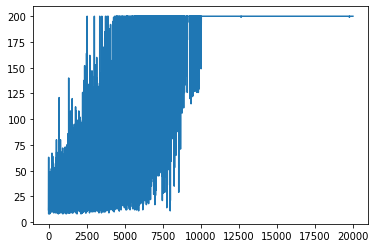

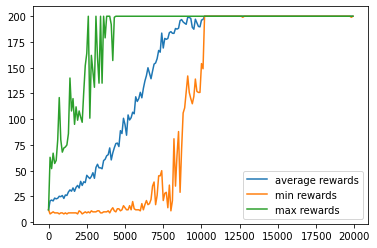

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.1
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 20000  # Number of iterations run
SHOW_EVERY = 2000  # How oftern the current solution is rendered
UPDATE_EVERY = 100  # How oftern the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


# Create bins and Q table
def create_bins_and_q_table():
    # env.observation_space.high
    # [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
    # env.observation_space.low
    # [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

    # remove hard coded Values when I know how to

    numBins = 20
    obsSpaceSize = len(env.observation_space.high)

    # Get the size of each bucket
    bins = [
        np.linspace(-4.8, 4.8, numBins),
        np.linspace(-4, 4, numBins),
        np.linspace(-.418, .418, numBins),
        np.linspace(-4, 4, numBins)
    ]

    #qTable = np.random.uniform(low=-2, high=0, size=([numBins] * obsSpaceSize + [env.action_space.n]))
    qTable = np.zeros([20, 20, 20, 20, 2])
    #qTable = np.zeros(numBins, obsSpaceSize, env.action_space.n)

    return bins, obsSpaceSize, qTable


# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
    stateIndex = []
    for i in range(obsSpaceSize):
        stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
    return tuple(stateIndex)


bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph
episodes = []
steps = []

for run in range(RUNS):
    discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
    done = False  # has the enviroment finished?
    cnt = 0  # how may movements cart has made
    episodes.append(run)

    while not done:
        #if run % SHOW_EVERY == 0:
            #env.render()  # if running RL comment this out

        cnt += 1
        # Get action from Q table
        if np.random.random() > epsilon:
            action = np.argmax(qTable[discreteState])
        # Get random action
        else:
            action = np.random.randint(0, env.action_space.n)

        newState, reward, done, _ = env.step(action)  # perform action on enviroment
        newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

        maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
        currentQ = qTable[discreteState + (action, )]  # old value

        # pole fell over / went out of bounds, negative reward
        if done and cnt < 200:
            reward = -375
            steps.append(cnt)

        # formula to caculate all Q values
        newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
        qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

        discreteState = newDiscreteState

    previousCnt.append(cnt)

    # Decaying is being done every run if run number is within decaying range
    if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # Add new metrics for graph
    if run % UPDATE_EVERY == 0:
        latestRuns = previousCnt[-UPDATE_EVERY:]
        averageCnt = sum(latestRuns) / len(latestRuns)
        metrics['ep'].append(run)
        metrics['avg'].append(averageCnt)
        metrics['min'].append(min(latestRuns))
        metrics['max'].append(max(latestRuns))
        print("Run:", run, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))

sns.lineplot(y=previousCnt, x=episodes)
plt.show()

env.close()

# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)
plt.show()